In [29]:
import pandas as pd
pd.set_option('display.max_columns', None)
import holoviews as hv
import geoviews as gv
import datashader as ds
from colorcet import fire, rainbow, bgy, bjy, bkr, kb, kr
from datashader.colors import colormap_select, Greys9
from holoviews.streams import RangeXY
from holoviews.operation.datashader import datashade, dynspread, rasterize
from holoviews import opts
from bokeh.io import push_notebook, show, output_notebook
from functools import partial
from datashader.utils import export_image
from IPython.core.display import HTML, display
from datashader import transfer_functions as tf
import matplotlib.pyplot as plt
import seaborn as sns
import sys
sys.path.append('../Scripts')

from utils import Map

C:\Users\Administrator\AppData\Local\Temp\ipykernel_8292\3858664036.py:14: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display


In [30]:
geo = pd.read_csv("../data/processed/geolocation.csv")
df = pd.read_csv("../data/processed/dataset_clear.csv")

In [31]:
df.head(3)

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,review_id,review_score,review_creation_date,review_answer_timestamp,payment_sequential,payment_type,payment_installments,payment_value,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english,delivery_time,late_delivery
0,fd826e7cf63160e536e0908c76c3f441,addec96d2e059c80c30fe6871d30d177,4534,sao paulo,SP,36e694cf4cbc2a4803200c35e84abdc4,delivered,2018-02-19 14:38:35,2018-02-19 14:50:37,2018-02-20 00:03:39,2018-02-20 16:25:51,2018-03-05,bc88d3b86fa8443d42894eb7b5f0d73c,5,2018-02-21 00:00:00,2018-02-26 13:53:18,1,credit_card,1,22.77,1,b5466db4cecf95c3c1be0ba32538ce1a,9f505651f4a6abe901a56cdc21508025,2018-02-23 14:50:37,14.99,7.78,informatica_acessorios,37.0,322.0,3.0,100.0,16.0,3.0,13.0,computers_accessories,1 days 01:35:14,False
1,5e274e7a0c3809e14aba7ad5aae0d407,57b2a98a409812fe9618067b6b8ebe4f,35182,timoteo,MG,1093c8304c7a003280dd34598194913d,delivered,2017-11-16 19:29:02,2017-11-16 19:55:41,2017-11-22 16:46:33,2017-11-27 12:44:36,2017-12-08,2381e1fb0932d9459573a0553dd8a2b5,3,2017-11-28 00:00:00,2017-11-28 17:14:46,1,credit_card,3,36.01,1,124f74f703e88efe001a10bfa718b6ff,2a7dc43cecabf23403078e2188437d1d,2017-11-22 19:55:41,19.90,16.11,unknown,52.0,600.0,1.0,250.0,15.0,8.0,20.0,unknown,10 days 16:48:55,False
2,5adf08e34b2e993982a47070956c5c65,1175e95fb47ddff9de6b2b06188f7e0d,81560,curitiba,PR,1ebeea841c590e86a14a0d7a48e7d062,delivered,2018-01-18 12:35:44,2018-01-18 12:56:32,2018-01-18 23:25:35,2018-01-26 15:17:57,2018-02-20,8566d94f7bf3bedbb4ca6a29725fc382,5,2018-01-27 00:00:00,2018-01-30 19:18:27,1,debit_card,1,39.10,1,08401f48b67a852d06105725c3013eff,95e03ca3d4146e4011985981aeb959b9,2018-01-30 12:56:32,25.00,14.10,brinquedos,58.0,739.0,5.0,350.0,28.0,10.0,12.0,toys,8 days 02:21:25,False


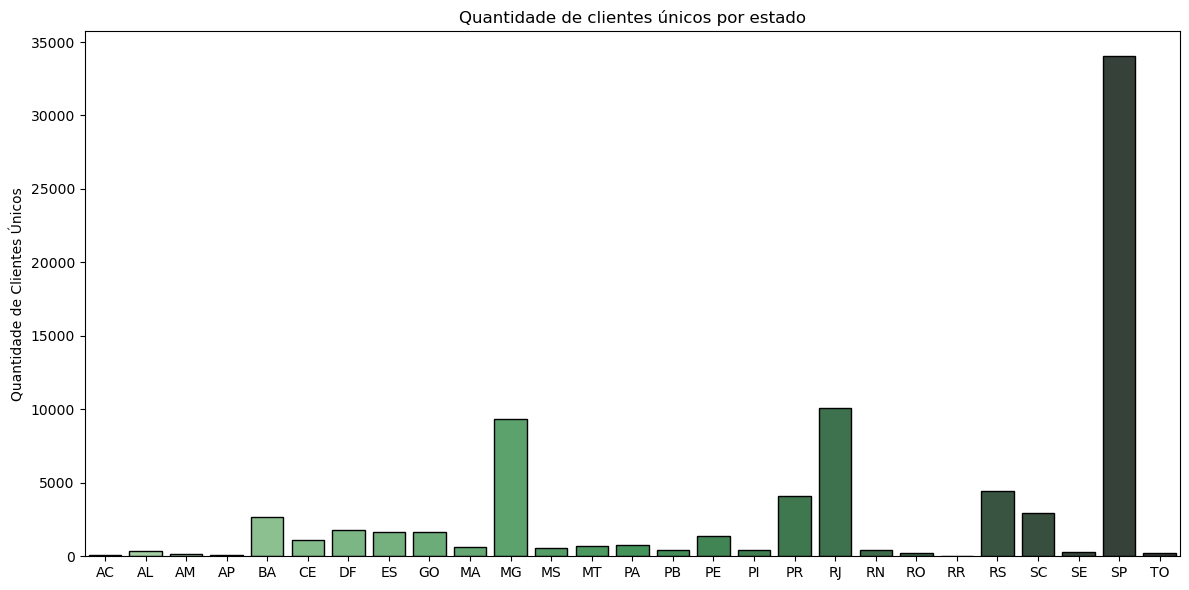

In [4]:
#Quantidade de clientes por estado (customer_state) e cidade (customer_city).
group = df.groupby('customer_state', as_index=False)['customer_unique_id'].nunique()
plt.figure(figsize=(12, 6))

sns.barplot(data=group, x='customer_state', y='customer_unique_id', hue='customer_state', 
            palette="Greens_d", edgecolor='black', legend=False)
plt.title('Quantidade de clientes únicos por estado')
plt.xlabel('')
plt.ylabel('Quantidade de Clientes Únicos')
plt.tight_layout()
plt.show()


In [32]:
brazil = geo
agg_name = 'geolocation_zip_code_prefix'
brazil[agg_name].describe().to_frame()

,geolocation_zip_code_prefix
count,1.000121e+06
mean,3.657332e+04
std,3.054939e+04
min,1.001000e+03
25%,1.107500e+04
50%,2.653000e+04
75%,6.350400e+04
max,9.999000e+04


Loading BokehJS ...

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
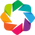

:DynamicMap   []
   :Overlay
      .WMTS.I     :WMTS   [Longitude,Latitude]
      .RGB.I      :RGB   [x,y]   (R,G,B,A)
      .QuadMesh.I :QuadMesh   [x,y]   (x_y geolocation_zip_code_prefix)

In [33]:
hv.opts.defaults(opts.QuadMesh(tools=['hover'], colorbar=True, alpha=0, hover_alpha=0.2))
mapa = Map()
grafico = mapa.plot_map(brazil, 'Zip Codes in Brazil', ds.min(agg_name), agg_name, cmap=rainbow)
grafico.opts(width=800, height=600, toolbar='above', xaxis=None, yaxis=None, title='Zip Codes in Brazil')

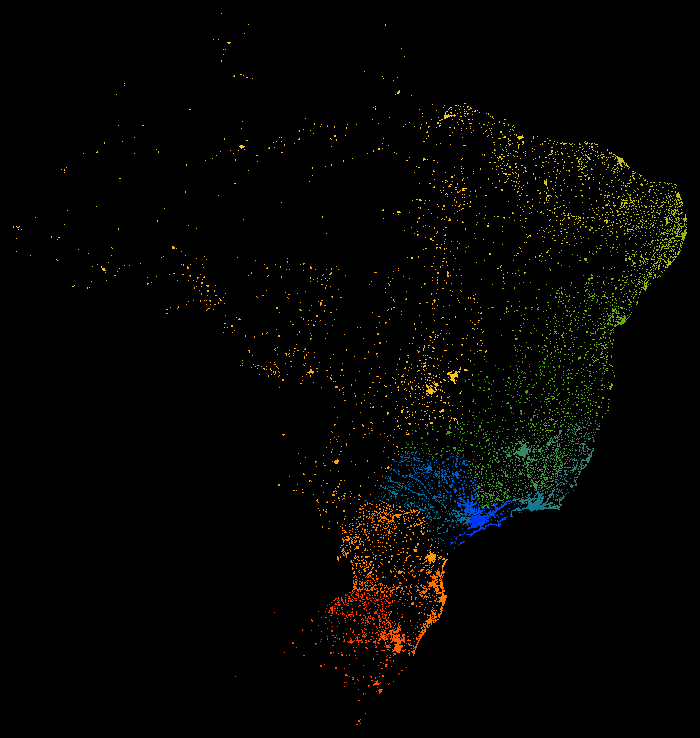

In [36]:
teste = create_map(brazil, rainbow, ds.mean(agg_name),'brazil_zip_codes')
teste

In [9]:
repeated = df['customer_unique_id'].value_counts()

# Filtra quem tem mais de 1 pedido
more_than_one_order = repeated[repeated > 1]

print(f"Número de clientes com mais de um pedido: {len(more_than_one_order)}")

Número de clientes com mais de um pedido: 12003


C:\Users\Administrator\AppData\Local\Temp\ipykernel_9372\1894524014.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=pedidos_por_cliente.values[pedidos_por_cliente.values <= 10], palette="Greens_d", edgecolor='black', legend=False)


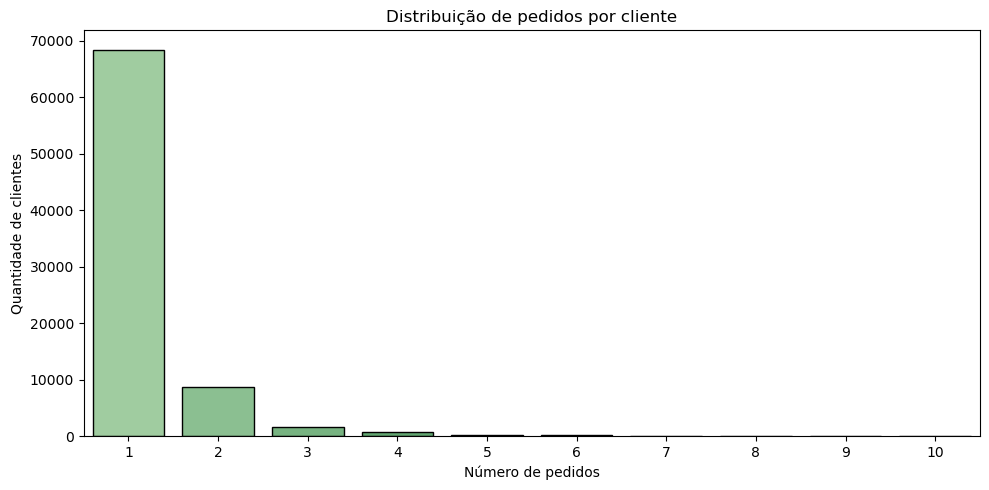

In [10]:
pedidos_por_cliente = df['customer_unique_id'].value_counts()
# Distribuição: quantos clientes fizeram 1 pedido, 2 pedidos, etc
plt.figure(figsize=(10, 5))
sns.countplot(x=pedidos_por_cliente.values[pedidos_por_cliente.values <= 10], palette="Greens_d", edgecolor='black', legend=False)
plt.title('Distribuição de pedidos por cliente')
plt.xlabel('Número de pedidos')
plt.ylabel('Quantidade de clientes')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

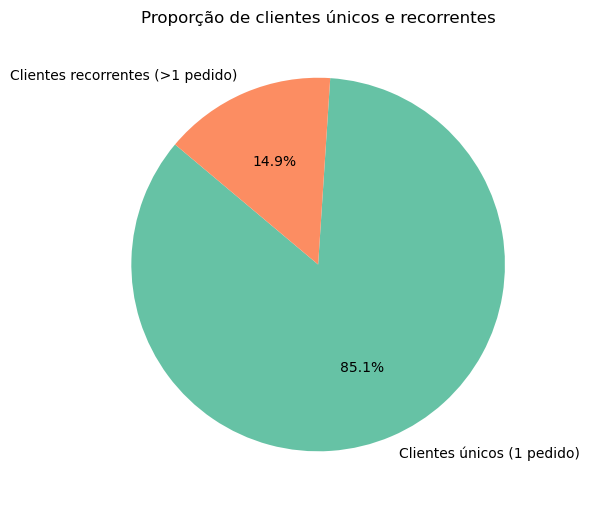

In [11]:
clientes_unicos = (pedidos_por_cliente == 1).sum()
clientes_recorrentes = (pedidos_por_cliente > 1).sum()

# Dados para o gráfico
labels = ['Clientes únicos (1 pedido)', 'Clientes recorrentes (>1 pedido)']
sizes = [clientes_unicos, clientes_recorrentes]
colors = ['#66c2a5', '#fc8d62']

plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors, startangle=140)
plt.title('Proporção de clientes únicos e recorrentes')
plt.tight_layout()
plt.show()


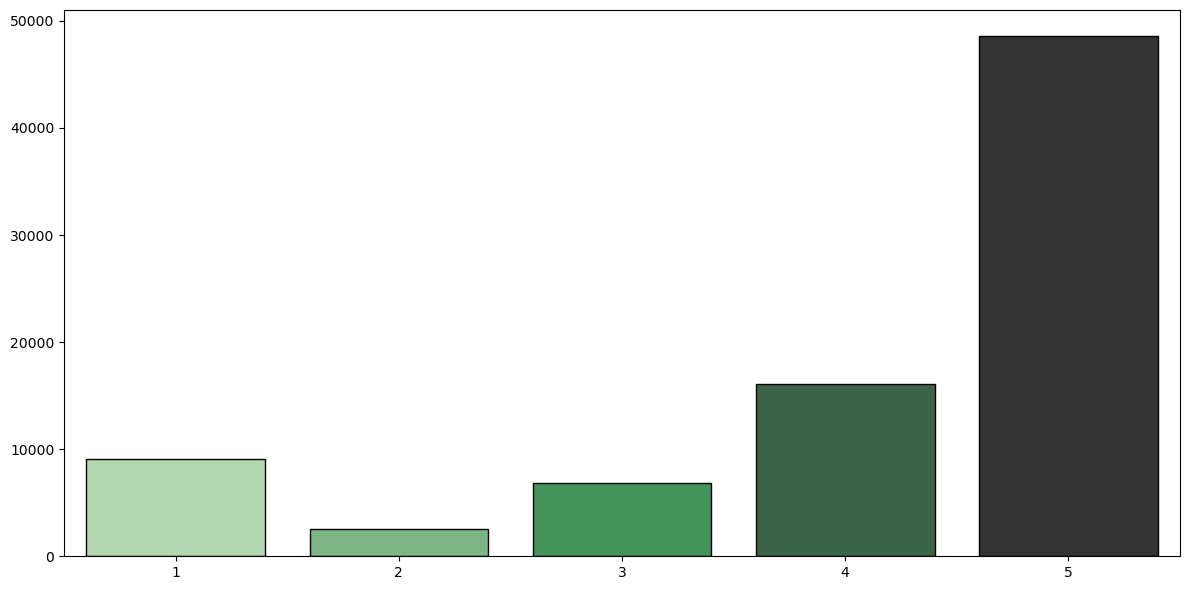

In [12]:
#Distribuição das review_score por cliente.

#Correlação entre entrega atrasada (late_delivery) e notas baixas.
group = df.groupby('review_score')['customer_id'].nunique().reset_index()
plt.figure(figsize=(12, 6))

sns.barplot(data=group, x='review_score', y='customer_id', hue='review_score', 
            palette="Greens_d", edgecolor='black', legend=False)
plt.title('')
plt.xlabel('')
plt.ylabel('')
plt.tight_layout()
plt.show()

In [13]:
df['order_purchase_timestamp'] = pd.to_datetime(df['order_purchase_timestamp'])
df['order_approved_at'] = pd.to_datetime(df['order_approved_at'])
df['order_delivered_carrier_date'] = pd.to_datetime(df['order_delivered_carrier_date'])
df['order_delivered_customer_date'] = pd.to_datetime(df['order_delivered_customer_date'])
df['order_estimated_delivery_date'] = pd.to_datetime(df['order_estimated_delivery_date'])
df['review_creation_date'] = pd.to_datetime(df['review_creation_date'], format='mixed', errors='coerce')
df['review_answer_timestamp'] = pd.to_datetime(df['review_answer_timestamp'])
df['shipping_limit_date'] = pd.to_datetime(df['shipping_limit_date'])

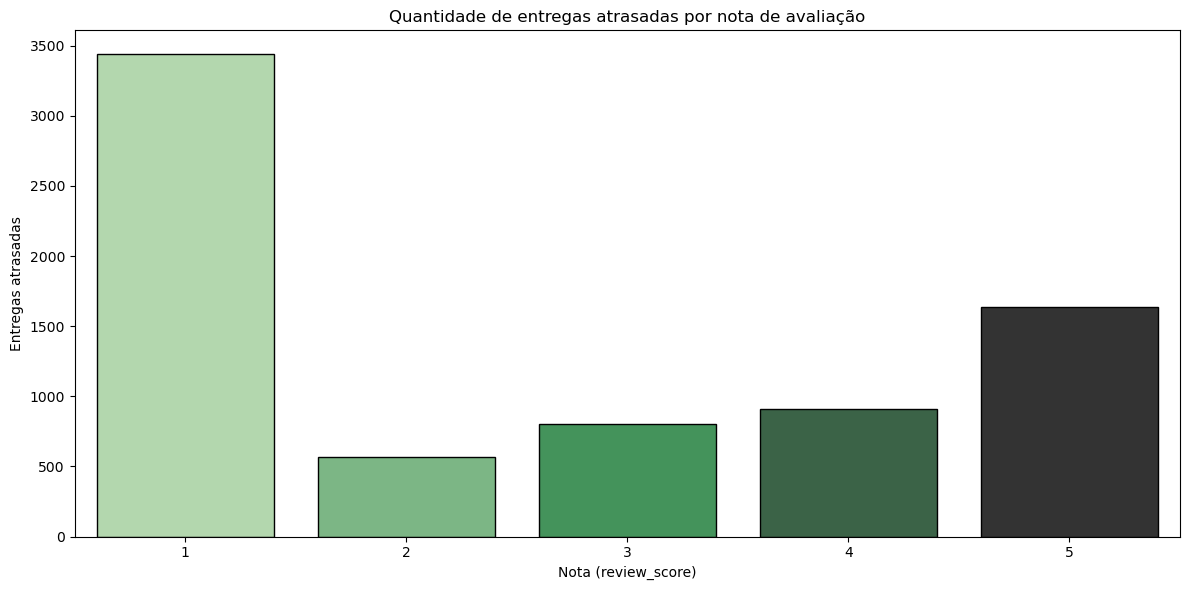

In [14]:
df['late_delivery'] = df['order_delivered_customer_date'] > df['order_estimated_delivery_date']
group = df.groupby('review_score')['late_delivery'].sum().reset_index()
plt.figure(figsize=(12, 6))

sns.barplot(data=group, x='review_score', y='late_delivery', hue='review_score', 
            palette="Greens_d", edgecolor='black', legend=False)
plt.title('Quantidade de entregas atrasadas por nota de avaliação')
plt.xlabel('Nota (review_score)')
plt.ylabel('Entregas atrasadas')
plt.tight_layout()
plt.show()

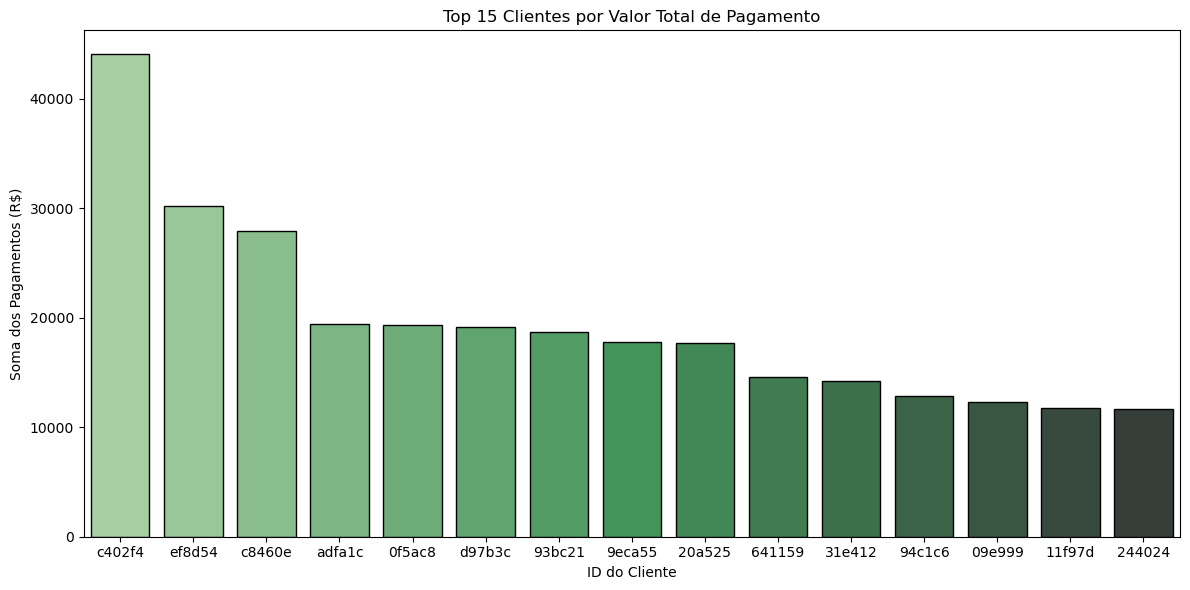

In [27]:
group = df.groupby('customer_unique_id')['payment_value'].sum().reset_index()
group = group.sort_values(by='payment_value', ascending=False)
group['short_id'] = group['customer_unique_id'].str[:6]
plt.figure(figsize=(12, 6))
sns.barplot(data=group.head(15), x='short_id', y='payment_value', hue='short_id',
            palette="Greens_d", edgecolor='black')
plt.title('Top 15 Clientes por Valor Total de Pagamento')
plt.xlabel('ID do Cliente')
plt.ylabel('Soma dos Pagamentos (R$)')
#plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

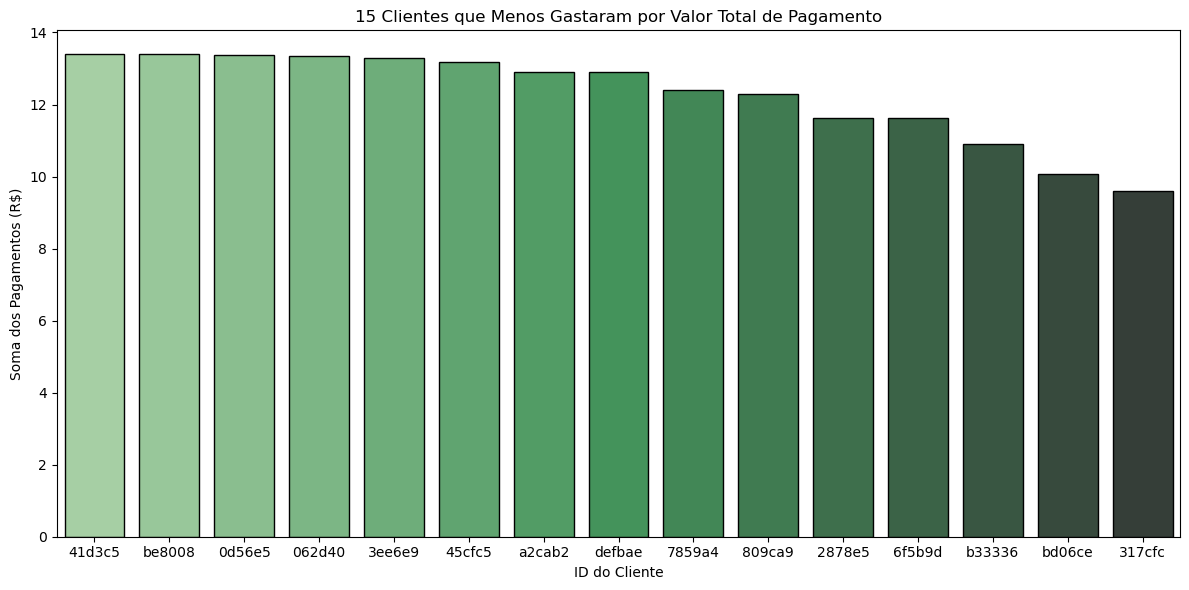

In [28]:
plt.figure(figsize=(12, 6))
sns.barplot(data=group.tail(15), x='short_id', y='payment_value', hue='short_id',
            palette="Greens_d", edgecolor='black')
plt.title('15 Clientes que Menos Gastaram por Valor Total de Pagamento')
plt.xlabel('ID do Cliente')
plt.ylabel('Soma dos Pagamentos (R$)')
#plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

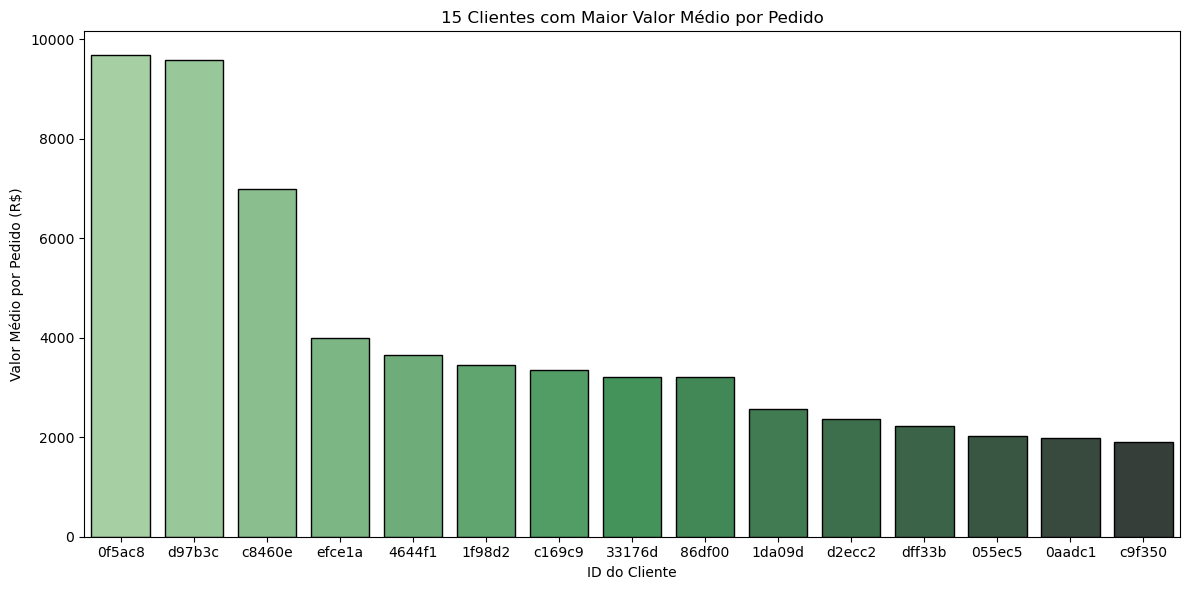

In [33]:
# 1. Soma dos pagamentos por cliente e pedido

# 2. Média de valor por pedido de cada cliente

pedidos_por_cliente = df.groupby(['customer_unique_id', 'order_id'])['payment_value'].sum().reset_index()
pedidos_validos = pedidos_por_cliente.groupby('customer_unique_id').filter(lambda x: len(x) > 1)

media_por_cliente = pedidos_validos.groupby('customer_unique_id')['payment_value'].mean().reset_index()

# 3. Ordenando
media_por_cliente = media_por_cliente.sort_values(by='payment_value', ascending=False)

# 4. Criando coluna com IDs encurtados
media_por_cliente['short_id'] = media_por_cliente['customer_unique_id'].str[:6]

# 5. Gráfico
plt.figure(figsize=(12, 6))
sns.barplot(data=media_por_cliente.head(15), x='short_id', y='payment_value', hue='short_id',
            palette="Greens_d", edgecolor='black')
plt.title('15 Clientes com Maior Valor Médio por Pedido')
plt.xlabel('ID do Cliente')
plt.ylabel('Valor Médio por Pedido (R$)')
plt.tight_layout()
plt.show()


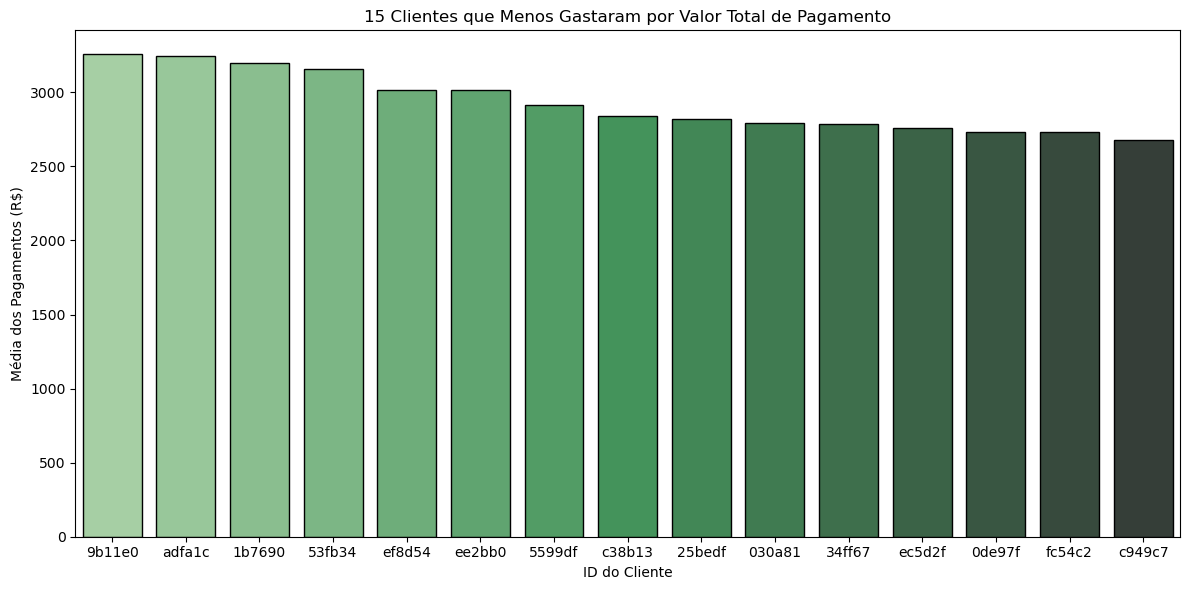

In [31]:
group = df.groupby('customer_unique_id')['payment_value'].mean().reset_index()
group = group.sort_values(by='payment_value', ascending=False)
group['short_id'] = group['customer_unique_id'].str[:6]
plt.figure(figsize=(12, 6))
sns.barplot(data=group.head(15), x='short_id', y='payment_value', hue='short_id',
            palette="Greens_d", edgecolor='black')
plt.title('15 Clientes que Menos Gastaram por Valor Total de Pagamento')
plt.xlabel('ID do Cliente')
plt.ylabel('Média dos Pagamentos (R$)')
#plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

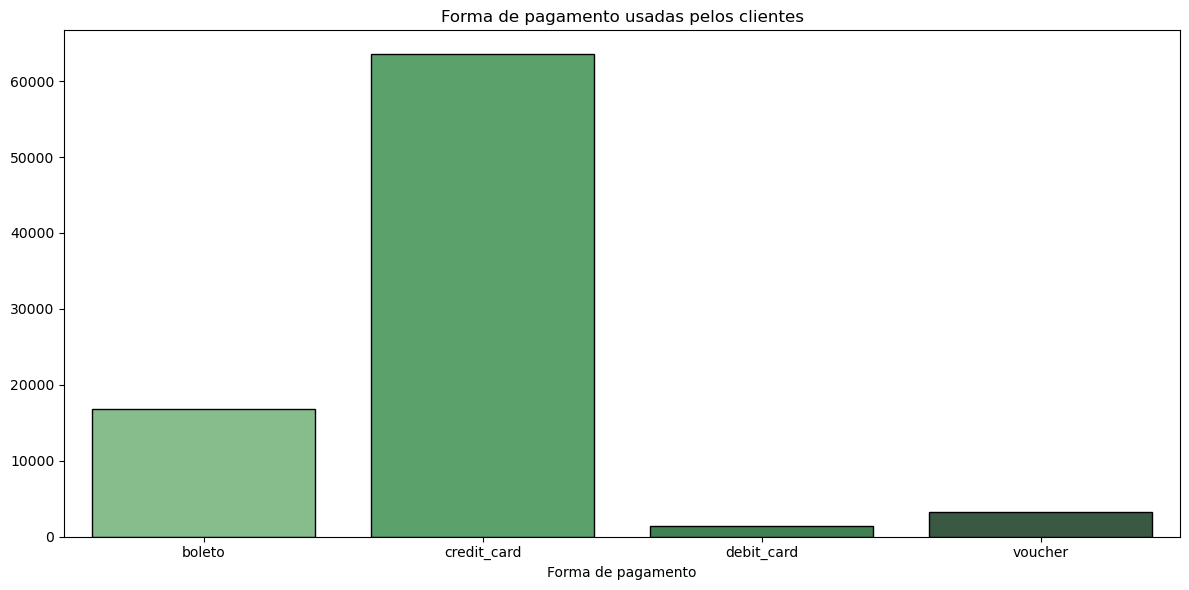

In [36]:
group = df.groupby('payment_type')['customer_id'].nunique().reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(data=group, x='payment_type', y='customer_id', hue='payment_type',
            palette="Greens_d", edgecolor='black')
plt.title('Forma de pagamento usadas pelos clientes')
plt.xlabel('Forma de pagamento')
plt.ylabel('')
#plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

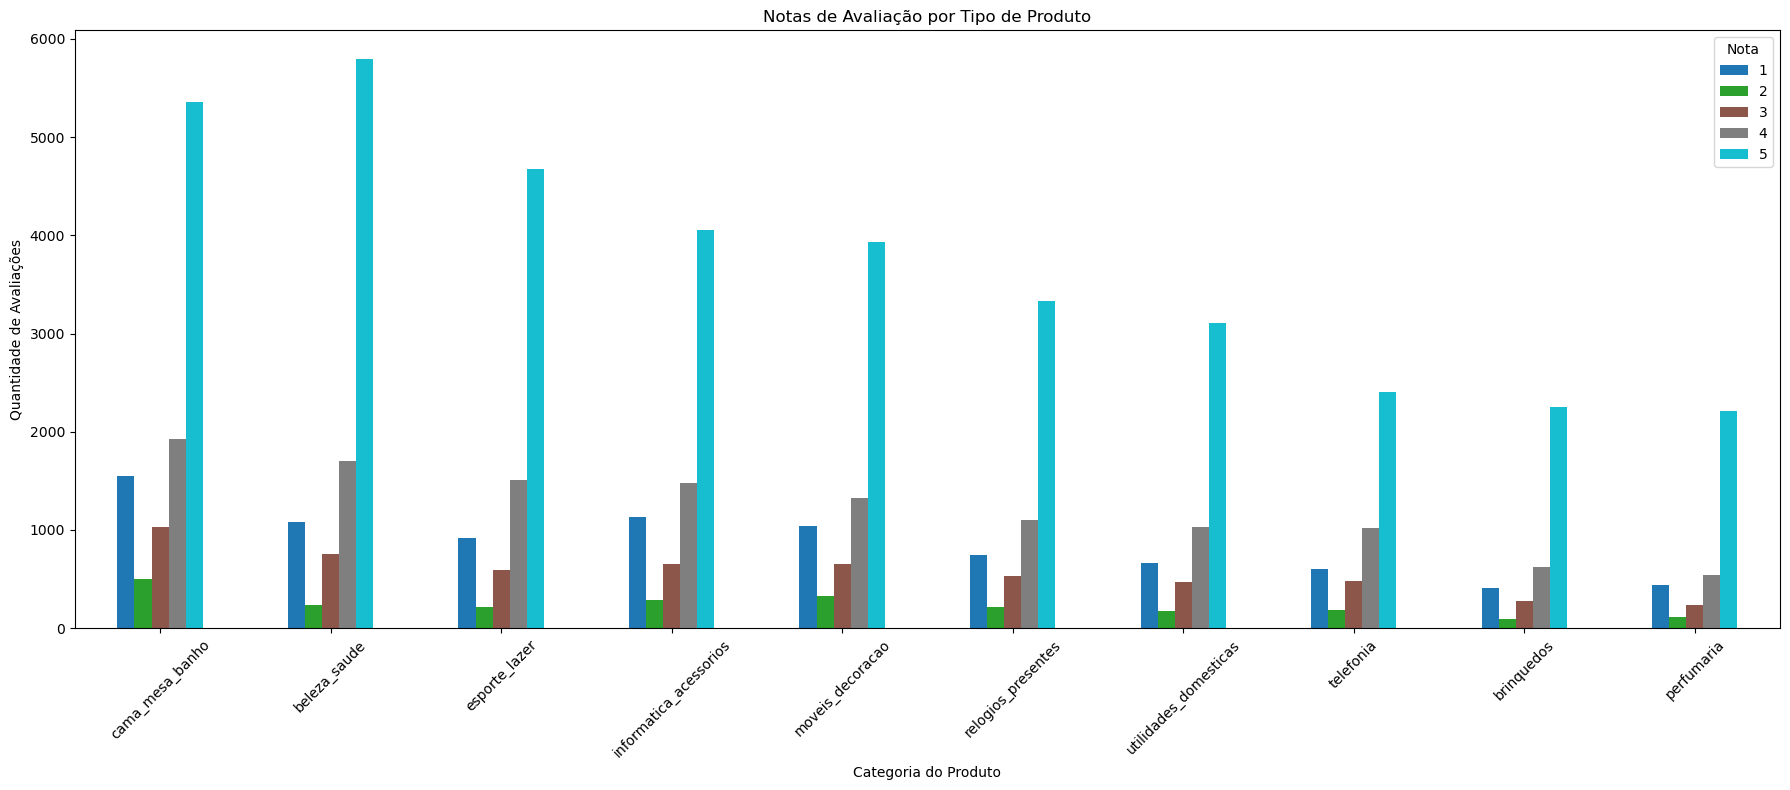

In [56]:
# Gráfico de boxplot
review_por_categoria = df.groupby(['product_category_name', 'review_score'])\
                                        .size().unstack(fill_value=0)

# Filtrar para as 10 categorias mais avaliadas
top_categorias = df['product_category_name'].value_counts().nlargest(10).index
review_por_categoria = review_por_categoria.loc[top_categorias]

# Plotar gráfico de barras agrupadas
review_por_categoria.plot(kind='bar', stacked=False, figsize=(18, 8), colormap="tab10")

plt.title('Notas de Avaliação por Tipo de Produto')
plt.xlabel('Categoria do Produto')
plt.ylabel('Quantidade de Avaliações')
plt.legend(title='Nota')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

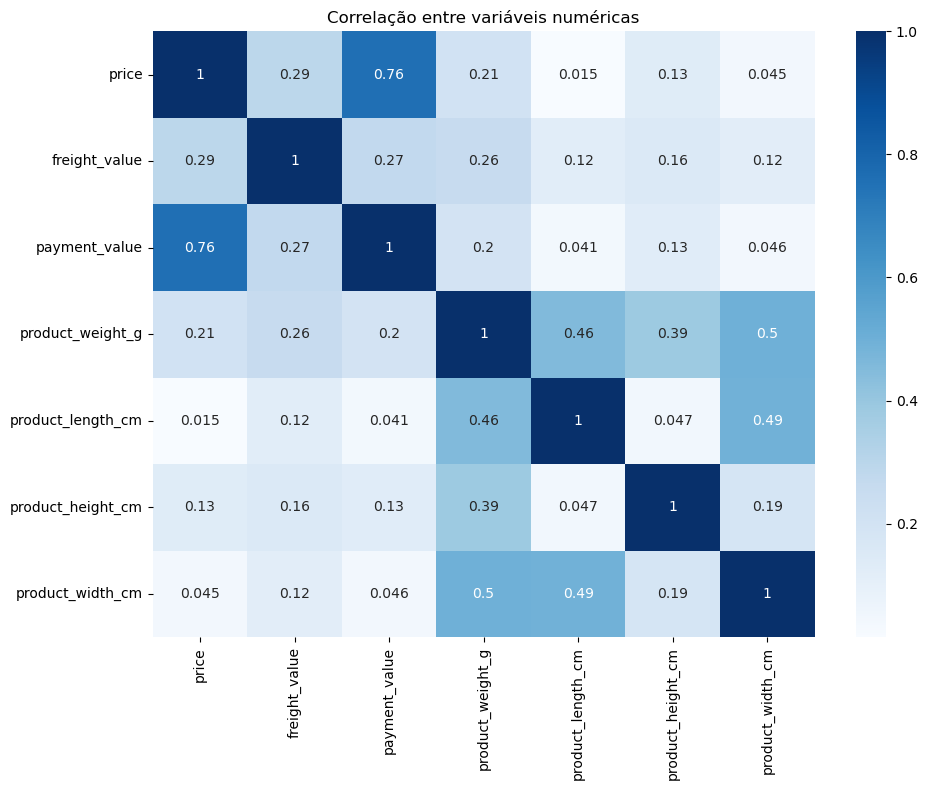

In [40]:
plt.figure(figsize=(10,8))
sns.heatmap(df[['price', 'freight_value', 'payment_value', 'product_weight_g', 
                'product_length_cm', 'product_height_cm', 'product_width_cm']].corr(), annot=True, cmap='Blues')
plt.title("Correlação entre variáveis numéricas")
plt.tight_layout()
plt.show()